# Regression Case Study

In [489]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error

In [25]:
train = pd.read_csv("data_regression/Train.zip")

In [3]:
train.shape

(401125, 53)

In [4]:
train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

In [6]:
cols = np.array(train.columns)

cols

array(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter',
       'UsageBand', 'saledate', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks',
       'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper',
       'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler',
       'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting',
       'Blade_Type', 'Travel_Controls', 'Differential_Type',
       'Steering_Controls'], dtype=object)

In [7]:
len(train['MachineID'].unique())

341027

In [8]:
na_count = pd.DataFrame(np.empty(shape=(1, len(cols))), columns = cols)

for i in cols:
    

    na_count[i] = (train[i].isnull().sum()/train.shape[0])*100

cols_2 = cols[(na_count <= 50).loc[0]]

len(cols_2)

18

After getting rid of the columns where more than 50% of the data where NA values, there were 18 columns remaining. This doesn't seem heplful because the features that remained on the dataset doesn't seem to be good predictors. Taking a look at the unique values of the features can give a better idea of what features are good.

This analysis was made by hand.

After taking a look at the unique values. It was determined which will and won't work.

Also, it is necessary to first classify the machines by it's group. This will certainly improve the sale price prediction.

To validate the previous assumption, let's calculate the mean sale price of each machine group.

In [9]:
train['ProductGroupDesc'].unique()

array(['Wheel Loader', 'Skid Steer Loaders', 'Track Excavators',
       'Backhoe Loaders', 'Track Type Tractors', 'Motor Graders'],
      dtype=object)

In [10]:
train_group = train.groupby('ProductGroupDesc')

train_group = train_group.aggregate(np.mean)

train_group['SalePrice']

ProductGroupDesc
Backhoe Loaders        20897.352553
Motor Graders          47251.564518
Skid Steer Loaders     10549.458563
Track Excavators       35666.120622
Track Type Tractors    36158.412221
Wheel Loader           37052.463249
Name: SalePrice, dtype: float64

So there is a difference in the mean price of every group. Let's see how are the prices distributed on each group.

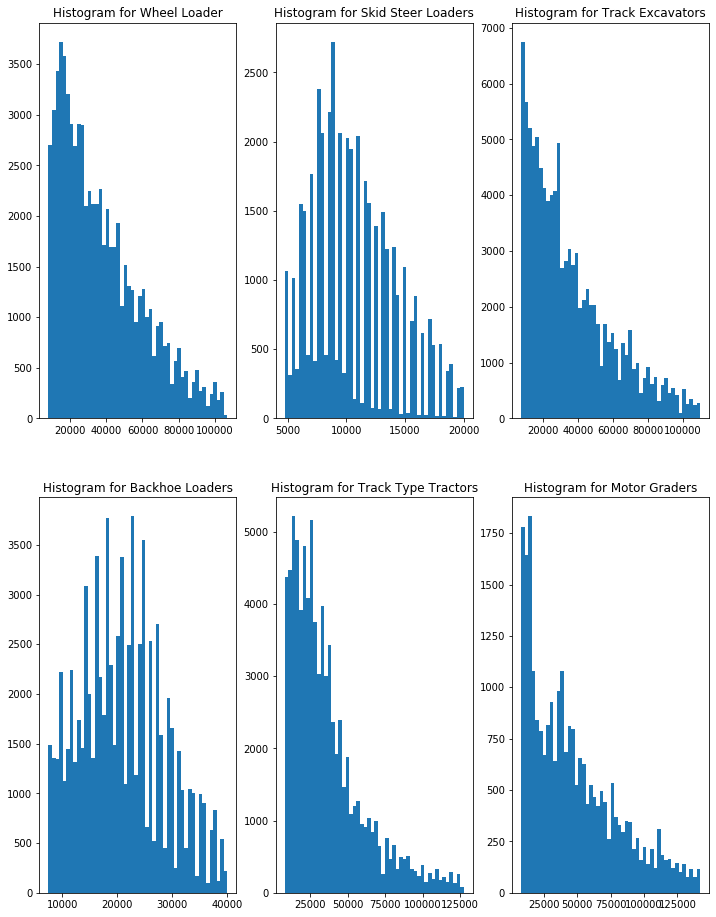

In [11]:
fig, ax = plt.subplots(2,3, figsize=(12,16))
prod = train['ProductGroupDesc'].unique()

for i, ax in enumerate(ax.flatten()):
    
    data = train[train['ProductGroupDesc'] == prod[i]]
    ax.hist(data['SalePrice'], bins=50)
    ax.set_title('Histogram for '+prod[i])

It's probable that the features are related to the type of machine that it's being analyzed. Therefore data will be split into 6 different datasets to determine which features are representative of the type of equipment.

In [12]:
train_WLoader = train[train['ProductGroupDesc'] == 'Wheel Loader']
train_SSLoader = train[train['ProductGroupDesc'] == 'Skid Steer Loaders']
train_TExc = train[train['ProductGroupDesc'] == 'Track Excavators']
train_BHLoad = train[train['ProductGroupDesc'] == 'Backhoe Loaders']
train_TTTrac = train[train['ProductGroupDesc'] == 'Track Type Tractors']
train_MGraders = train[train['ProductGroupDesc'] == 'Motor Graders']

In [13]:
datasets = [train_WLoader,train_SSLoader,train_TExc,train_BHLoad,train_TTTrac,train_MGraders]

print('Rows of Wheel Loader: ',len(train_WLoader))
print('Rows of Skid Steer Loader: ',len(train_SSLoader))
print('Rows of Track Excavator: ',len(train_TExc))
print('Rows of Backhoe Loader: ',len(train_BHLoad))
print('Rows of Track Type Tractor: ',len(train_TTTrac))
print('Rows of Motor Graders: ',len(train_MGraders))


Rows of Wheel Loader:  71046
Rows of Skid Steer Loader:  43488
Rows of Track Excavator:  101167
Rows of Backhoe Loader:  79415
Rows of Track Type Tractor:  80520
Rows of Motor Graders:  25489


In [15]:
na_list = pd.DataFrame(np.empty(shape=(6, len(cols))), columns = cols)
na_vals = {}

for n,i in enumerate(datasets):
    
    for m in cols:
        
        na_vals.update({m: i[m].isnull().sum() * 100 / len(i)})
        print(n, m)
    na_list.iloc[n] = na_vals

na_list

0 SalesID
0 SalePrice
0 MachineID
0 ModelID
0 datasource
0 auctioneerID
0 YearMade
0 MachineHoursCurrentMeter
0 UsageBand
0 saledate
0 fiModelDesc
0 fiBaseModel
0 fiSecondaryDesc
0 fiModelSeries
0 fiModelDescriptor
0 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
0 Drive_System
0 Enclosure
0 Forks
0 Pad_Type
0 Ride_Control
0 Stick
0 Transmission
0 Turbocharged
0 Blade_Extension
0 Blade_Width
0 Enclosure_Type
0 Engine_Horsepower
0 Hydraulics
0 Pushblock
0 Ripper
0 Scarifier
0 Tip_Control
0 Tire_Size
0 Coupler
0 Coupler_System
0 Grouser_Tracks
0 Hydraulics_Flow
0 Track_Type
0 Undercarriage_Pad_Width
0 Stick_Length
0 Thumb
0 Pattern_Changer
0 Grouser_Type
0 Backhoe_Mounting
0 Blade_Type
0 Travel_Controls
0 Differential_Type
0 Steering_Controls
1 SalesID
1 SalePrice
1 MachineID
1 ModelID
1 datasource
1 auctioneerID
1 YearMade
1 MachineHoursCurrentMeter
1 UsageBand
1 saledate
1 fiModelDesc
1 fiBaseModel
1 fiSecondaryDesc
1 fiModelSeries
1 fiModelDescriptor
1 Prod

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,0.0,0.0,0.0,0.0,0.0,3.820060,0.0,64.085241,84.736649,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2.301326,2.360443
1,0.0,0.0,0.0,0.0,0.0,4.070088,0.0,61.345659,75.252943,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,0.0,0.0,0.0,0.0,0.0,5.981199,0.0,64.110827,80.337462,0.0,...,1.280062,1.926518,1.857325,1.926518,1.990768,100.000000,100.000000,100.000000,100.000000,100.000000
3,0.0,0.0,0.0,0.0,0.0,5.914500,0.0,66.770761,84.251086,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,0.0,0.0,0.0,0.0,0.0,4.731744,0.0,64.181570,84.036264,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,2.295082,0.853204,0.851962,100.000000,100.000000
5,0.0,0.0,0.0,0.0,0.0,4.292048,0.0,65.079054,89.093334,0.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


We'll remove the Machine ID, ModelID, datasource and auctionerID columns since they don't actually relate to the sale price.

In [503]:
def scale_y(y):
        
    y = (y - y.mean())/(np.std(y))

    return y

def scale_X(X):
    
    for i in X.columns:
        
        X[i] = (X[i] - X[i].mean())/(np.std(X[i]))

    return X

In [101]:
for n,i in enumerate(datasets):
    
    for m in cols:
        
        if na_list[m][n] > 30:
            
            i.drop(m, axis = 1, inplace=True)
        else:
            
            pass


In [102]:
for i in datasets:
    
    i.drop(['SalesID','MachineID','ModelID','datasource','auctioneerID'], axis=1, inplace=True)

Now that the information is filtered, the datasets will be split into train and test datasets. Also, the name of the regressors for each type of machine will stored to avoid missing columns in the actual test set.

In [478]:
def clean_data(X):
    
    #Create empty list that will store the datasets for each type of product
    datasets_reg = []
    datasets_true = []
    cols = X.columns
    
    
    #Create a dataset for each of the product types
    
    for c in X['ProductGroupDesc'].unique():
        
        if c == 'Wheel Loader':
            
            X_WLoader = X[X['ProductGroupDesc'] == 'Wheel Loader']
            datasets_reg.append(X_WLoader)
            
            y_WLoader = X_WLoader['SalePrice']
            datasets_true.append(y_WLoader)
            
            
        elif c == 'Skid Steer Loaders':
        
            X_SSLoader = X[X['ProductGroupDesc'] == 'Skid Steer Loaders']
            datasets_reg.append(X_SSLoader)
            
            y_SSLoader = X_SSLoader['SalePrice']
            datasets_true.append(y_SSLoader)
            
        
        elif c == 'Track Excavators':
            
            X_TExc = X[X['ProductGroupDesc'] == 'Track Excavators']
            datasets_reg.append(X_TExc)
            
            y_TExc = X_TExc['SalePrice']
            datasets_true.append(y_TExc)
            
        
        elif c == 'Backhoe Loaders':
            
            X_BHLoad = X[X['ProductGroupDesc'] == 'Backhoe Loaders']
            datasets_reg.append(X_BHLoad)
            
            y_BHLoad = X_BHLoad['SalePrice']
            datasets_true.append(y_BHLoad)
            
        
        elif c == 'Track Type Tractors':
            
                X_TTTrac = X[X['ProductGroupDesc'] == 'Track Type Tractors']
                datasets_reg.append(X_TTTrac)
                
                y_TTTrac = X_TTTrac['SalePrice']
                datasets_true.append(y_TTTrac)
                
        
        elif c == 'Motor Graders':
    
                X_MGraders = X[X['ProductGroupDesc'] == 'Motor Graders']
                datasets_reg.append(X_MGraders)
            
                y_MGraders = X_MGraders['SalePrice']
                datasets_true.append(y_MGraders)
                
        
        
    #This part takes out the columns where no relevant data is stored
    
    na_DF = pd.DataFrame(np.empty(shape=(6, len(cols))), columns = cols)
    na_vals = {}

    for n,i in enumerate(datasets_reg):
            
        for m in cols:
        
            na_vals.update({m: i[m].isnull().sum() * 100 / len(i)})
            
            
        na_DF.iloc[n] = na_vals

     
    #Loop that deletes rows where NA values are more than 30% of total data   
    for n,i in enumerate(datasets_reg):
    
        for m in cols:
        
            if na_DF[m][n] > 30:
            
                i.drop(m, axis = 1, inplace=True)
                
            else:
            
                pass 
    
    
    #This part gets rid of columns that don't add relvant information to the sale price
    
    for i in datasets_reg:
        
        i.drop(['SalePrice','SalesID','MachineID','ModelID','datasource','auctioneerID','saledate','fiModelDesc','fiProductClassDesc','ProductGroupDesc','ProductGroup'], axis = 1, inplace = True)
        
    #Deleting remaining NA values
    for i in datasets_reg:
        
        i.dropna(axis= 0, inplace = True)
    
    
    #True values with the same indices of the resulting regresors dataframe
    
    for i in range(len(datasets_reg)):
        
        datasets_true[i] = datasets_true[i].loc[datasets_reg[i].index]
    
    
    for i in range(len(datasets_reg)):
        
        datasets_reg[i].reset_index(inplace = True)
        datasets_reg[i].drop('index',axis = 1, inplace = True)
        t = datasets_reg[i]
        new_data = pd.DataFrame()
        
        for m in datasets_reg[i].columns:
            
            if m != 'YearMade':
                
                new_cols = pd.get_dummies(datasets_reg[i][m])
                new_data = pd.concat([t.drop(m,axis = 1), new_cols], axis = 1)
                
                t = new_data
            
        datasets_reg[i] = new_data
        
    
    
    return datasets_reg, datasets_true


In [530]:
reg, true = clean_data(train)

/Library/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [538]:
def fit_model(datasets_reg, datasets_true, model):
    
    mod = model
    
    r = []
    
    for n in range(len(datasets_reg)):
        
        
        train_X, test_X, train_y, test_y = train_test_split(datasets_reg[n], datasets_true[n], test_size = 0.3)
        
        train_X = scale_X(train_X)
        test_X = scale_X(train_X)
        train_y = scale_y(train_y)
        test_y = scale_y(test_y)
        
        res = mod.fit(train_X, train_y).predict(test_X)
        res = (res*np.std(datasets_true[n]))+(datasets_true[n].mean())
        
        
        r.append(mean_squareed_log_error(datasets_true[n], res))
        
    return r        

In [539]:
fit_model(reg, true, LinearRegression())

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [518]:
train_X, test_X, train_y, test_y = train_test_split(reg[1], true[1], test_size = 0.3)

In [524]:
train_y = scale_y(train_y)
test_true = scale_y(test_y)

res = Ridge(alpha=2).fit(train_X, train_y).predict(test_X)
t = (res*np.std(test_y))+(test_y.mean())

mean_squared_log_error(test_y, t)

0.05775339624248319